# Data Augmentation and Regularization Techniques for CNNs on CIFAR-10

Several improvements can be done on the CNN architecture to enhance its performance on the CIFAR-10 dataset and prevent overfitting. These improvements include data augmentation and regularization techniques.

We can recall that our previous best performing CNN model on this dataset, nicknamed DeepCNN, had around 72% validation accuracy. This can be increased significantly.

## Data Augmentation

The base architecture of the CNN is the same as in the previous notebook, but the data of the CIFAR-10 dataset is augmented to provide more training examples, which helps prevent overfitting.

Each image in the training data has a random rotation, translation, and horizontal flip applied to it. This helps the model generalize better to different image orientations and positions.

## Setup

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import copy
import pandas as pd
import utils
from torch.optim.lr_scheduler import CosineAnnealingLR

Calculate dataset statistics for normalization and add augmentation techniques to the transform

In [2]:
raw_train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
raw_pixels = raw_train_data.data
pixels_scaled = raw_pixels / 255.0 # scale to [0,1] range
dataset_means = pixels_scaled.mean(axis=(0, 1, 2))
dataset_stds = pixels_scaled.std(axis=(0, 1, 2))

# transform with augmentation
transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Adds a 4px border, then crops a 32x32 square randomly
    transforms.RandomHorizontalFlip(), # 50% chance to flip the image horizontally
    transforms.ToTensor(),
    transforms.Normalize(dataset_means, dataset_stds)
])

# transform without
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(dataset_means, dataset_stds)
])

100%|██████████| 170M/170M [00:04<00:00, 39.1MB/s]


In [3]:
# Download training and test sets and normalize
train_aug_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_augment)
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

val_data = torch.utils.data.Subset(full_test_data, indices=list(range(5000)))
test_data = torch.utils.data.Subset(full_test_data, indices=list(range(5000, 10000)))

# Create DataLoaders
batch_size = 64
augtrainloader = DataLoader(train_aug_data, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

## Model Definition

We will use the same architecture as the deep CNN of the previous notebook as it performed well on the dataset and showed the least signs of overfitting. This model will be further regularized by adding two optional regularization techniques, which will be tested later on:

* **Dropout**: Randomly sets a fraction of input units to 0 at each update during training, which helps prevent overfitting by reducing co-adaptation of neurons. By deactivating some neurons in each training iteration, the model learns to generalize with just a smaller set of parameters, which becomes more robust overall. Dropout improves the model's **generalization**, meaning how well it can generalize to new data it has never seen before.

* **Batch Normalization**: Normalizes the activations of each layer (mean of 0, std of 1) before passing it to the next layer, which stabilizes training. Just like normalization was crucial before training, batch normalization helps the deeper convolutional layers apply small gradient changes without exploding. Batch Normalization improves the model's **optimization**, meaning how fast it can memorize the data in front of it.

In [4]:
class FlexibleDeepCNN(nn.Module):
    def __init__(self, batch_norm=True, dropout_prob=0.2):
        super().__init__()
        # Block 1: 32x32x3 in -> 16x16x16 out
        self.conv1a = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2: 16x16x16 in -> 8x8x32 out
        self.conv2a = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        if batch_norm:
            self.bn1a = nn.BatchNorm2d(16)
            self.bn1b = nn.BatchNorm2d(16)
            self.bn2a = nn.BatchNorm2d(32)
            self.bn2b = nn.BatchNorm2d(32)
        else:
            self.bn1a = self.bn1b = self.bn2a = self.bn2b = lambda x: x

        # Classifier
        self.fc1 = nn.Linear(8 * 8 * 32, 128)
        self.dropout = nn.Dropout(dropout_prob) # 50% chance to drop a neuron
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = self.pool(F.relu(self.bn1b(self.conv1b(x))))

        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = self.pool(F.relu(self.bn2b(self.conv2b(x))))

        # Classifier
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## Training
The evaluate and train_CNN from the previous notebook are also used here as-is, except we add in the training function support for a learning rate scheduler. This will allow us to use schedulers that lower the learning rate over time, which helps speed up training by using higher lr at the start that would otherwise miss the optimum if not lowered.

In [5]:
def evaluate(model, testloader, criterion, device):
    model.eval()  # Set to evaluation mode (turns off Dropout/BatchNorm)
    test_loss = 0
    correct = 0
    with torch.no_grad():  # No gradient calculation saved (saves memory)
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

    loss = test_loss / len(testloader)
    acc = 100. * correct / len(testloader.dataset)
    return loss, acc

In [6]:
def train_CNN(model, trainloader, valloader, criterion, optimizer, device, epochs=5,
               console=False, early_stopping=False, patience=3, scheduler=None):
    model.to(device)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    best_val_loss = float('inf') # For early stopping
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improvement_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        if scheduler:
          scheduler.step()

        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        epoch_val_loss, epoch_val_acc = evaluate(model, valloader, criterion, device)

        # Save to history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        if console:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")

        if early_stopping:
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                # Save the best model weights
                best_model_wts = copy.deepcopy(model.state_dict())
                no_improvement_counter = 0 # Reset counter
            else:
                no_improvement_counter += 1
                if console: print(f"  EarlyStopping counter: {no_improvement_counter} out of {patience}")

                if no_improvement_counter >= patience:
                    if console: print("Early stopping triggered! Restoring best weights...")
                    model.load_state_dict(best_model_wts) # Restore best model
                    break

    if console: print("Finished Training")
    return history

### Evaluation

To isolate the different variables that may improve overfitting in an experiment, four different models will be evaluated:
* The exact same deep CNN from the previous notebook but on the augmented dataset
* Deep CNN with dropout on the original dataset
* Deep CNN with batch normalization
* Deep CNN with both dropout and batch normalization

The models are also trained for 20 epochs instead of 10. This is because by solving overfitting, the model can be trained for longer, which may be necessary for data augmentation since it introduces much more data and thus requires more training to generalize well.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

models = {
    'data_augmentation': FlexibleDeepCNN(batch_norm=False, dropout_prob=0).to(device),
    'dropout': FlexibleDeepCNN(batch_norm=False, dropout_prob=0.5).to(device),
    'batchnorm': FlexibleDeepCNN(batch_norm=True, dropout_prob=0).to(device),
    'dropout_batchnorm': FlexibleDeepCNN(batch_norm=True, dropout_prob=0.5).to(device)
}

results_data = []
histories = dict()

# training for each model
for name, model in models.items():
    if name == 'data_augmentation':
        loader = augtrainloader
    else:
        loader = trainloader

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = train_CNN(model, loader, valloader, criterion, optimizer, device,
                        epochs=20, early_stopping=True)

    final_train = history['train_acc'][-1]
    final_val = history['val_acc'][-1]
    results_data.append({
        'Model': name,
        'Train Acc': final_train,
        'Val Acc': final_val,
        'Gap': final_train - final_val
    })
    histories[name] = history

    print(f"{name:<10} | Train Acc: {final_train:.2f}% | Val Acc: {final_val:.2f}%")


data_augmentation | Train Acc: 77.39% | Val Acc: 77.50%
dropout    | Train Acc: 76.84% | Val Acc: 73.84%
batchnorm  | Train Acc: 87.32% | Val Acc: 75.24%
dropout_batchnorm | Train Acc: 75.93% | Val Acc: 75.74%


### Results

,Model,Train Acc,Val Acc,Gap
0,data_augmentation,77.394,77.50,-0.106
1,dropout,76.840,73.84,3.000
2,batchnorm,87.322,75.24,12.082
3,dropout_batchnorm,75.928,75.74,0.188


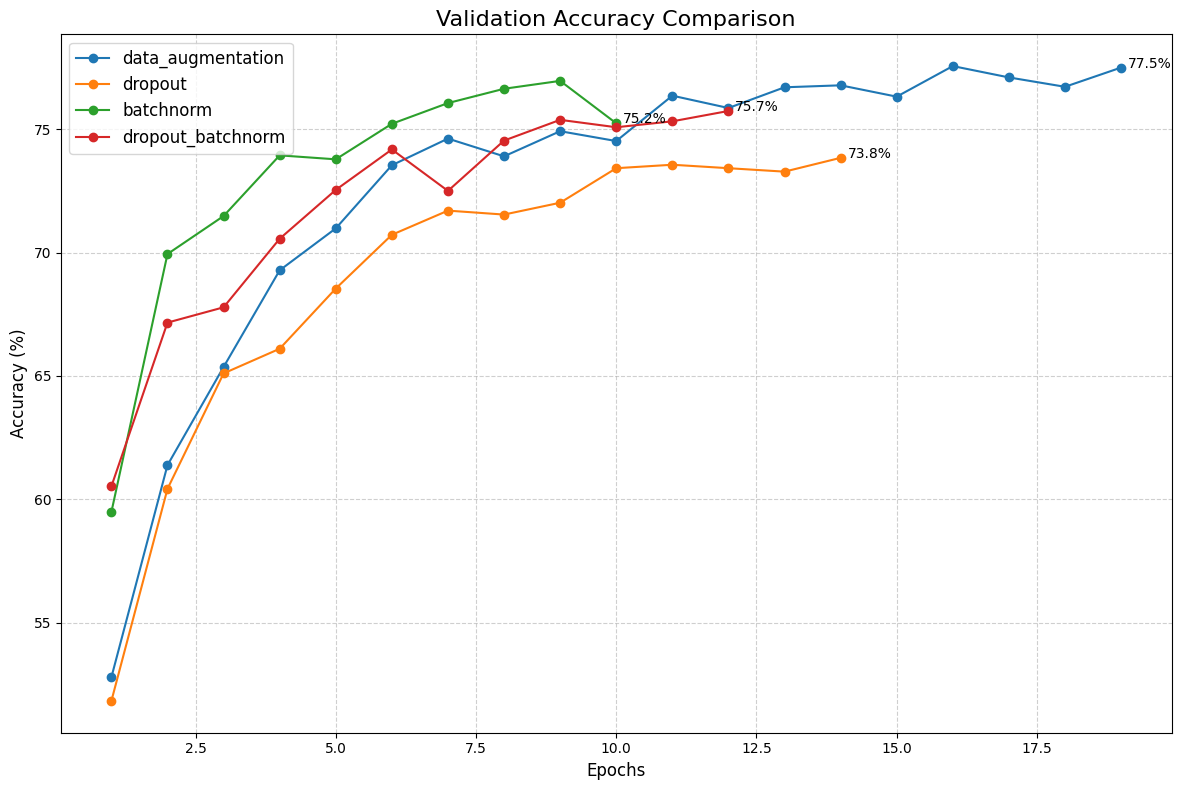

In [8]:
df_results = pd.DataFrame(results_data)
display(df_results)
utils.plot_validation_curves(histories)

These results reveal an important distinction between the two regularization techniques. Batch Normalization helps immensely to learn by normalizing each layer to a range that is much more convenient to apply gradient descent to and improve. However, it does not solve overfitting on its own. This is evident in how the accuracies gap actually increases to 12 in the model that used Batch Normalization on the unaltered dataset.

On the other hand, Dropout helps the model generalize better to unseen data by randomly deactivating neurons, which allows the model to learn with a smaller set of unrelated parameters. This makes the model more robust and less prone to overfitting. The dropout model indeed achieved a smaller accuracies gap than in the previous notebook (3%), but the validation accuracy only marginally improved, so the effectiveness of Dropout is questionable.

The combination of Dropout and Data Augmentation provided a better improvement than either of these on their own, and Data Augmentation is the most promising improvement. Perhaps the dataset was simply too small without augmentation for the model to generalize well. The combination of Dropout and Batch Normalization on the augmented dataset could be a good candidate for further exploration.

## Further Exploration

Data Augmentation is used on several models in an attempt to improve generalization. We will compare different dropout probability values to find the optimal configuration. We test:
* One deep CNN with batch normalization on the augmented dataset
* Four deep CNN's with both dropout and batch normalization, with a dropout probability in the range [0.2, 0.8]

This time we intend to train our models for much longer, so that they converge closer on the optimum. This becomes evidently necessary because the previous attempts finished as the loss curves continued to decrease and accuracy continued to slowly climb. We include a learning rate scheduler, which will lower the learning rate over time as epochs increase - this is intended to help the model converge exactly on the optimum and not miss it, as 0.001 might be a lr too fast during long training.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

models = {
    'batchnorm': FlexibleDeepCNN(batch_norm=True, dropout_prob=0).to(device),
    'dropout_0.2': FlexibleDeepCNN(batch_norm=True, dropout_prob=0.2).to(device),
    'dropout_0.4': FlexibleDeepCNN(batch_norm=True, dropout_prob=0.4).to(device),
    'dropout_0.6': FlexibleDeepCNN(batch_norm=True, dropout_prob=0.6).to(device),
    'dropout_0.8': FlexibleDeepCNN(batch_norm=True, dropout_prob=0.8).to(device)
}

results_data = []
histories = dict()

# training for each model
for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    cos_scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

    history = train_CNN(model, augtrainloader, valloader, criterion, optimizer, device,
                        epochs=30, early_stopping=True, patience=5, scheduler=cos_scheduler)

    final_train = history['train_acc'][-1]
    final_val = history['val_acc'][-1]
    results_data.append({
        'Model': name,
        'Train Acc': final_train,
        'Val Acc': final_val,
        'Gap': final_train - final_val
    })
    histories[name] = history

    print(f"{name:<10} | Train Acc: {final_train:.2f}% | Val Acc: {final_val:.2f}%")


batchnorm  | Train Acc: 81.58% | Val Acc: 81.80%
dropout_0.2 | Train Acc: 77.29% | Val Acc: 79.92%
dropout_0.4 | Train Acc: 71.46% | Val Acc: 77.86%
dropout_0.6 | Train Acc: 59.41% | Val Acc: 72.80%
dropout_0.8 | Train Acc: 41.32% | Val Acc: 59.24%


### Results

,Model,Train Acc,Val Acc,Gap
0,batchnorm,81.582,81.80,-0.218
1,dropout_0.2,77.294,79.92,-2.626
2,dropout_0.4,71.458,77.86,-6.402
3,dropout_0.6,59.412,72.80,-13.388
4,dropout_0.8,41.322,59.24,-17.918


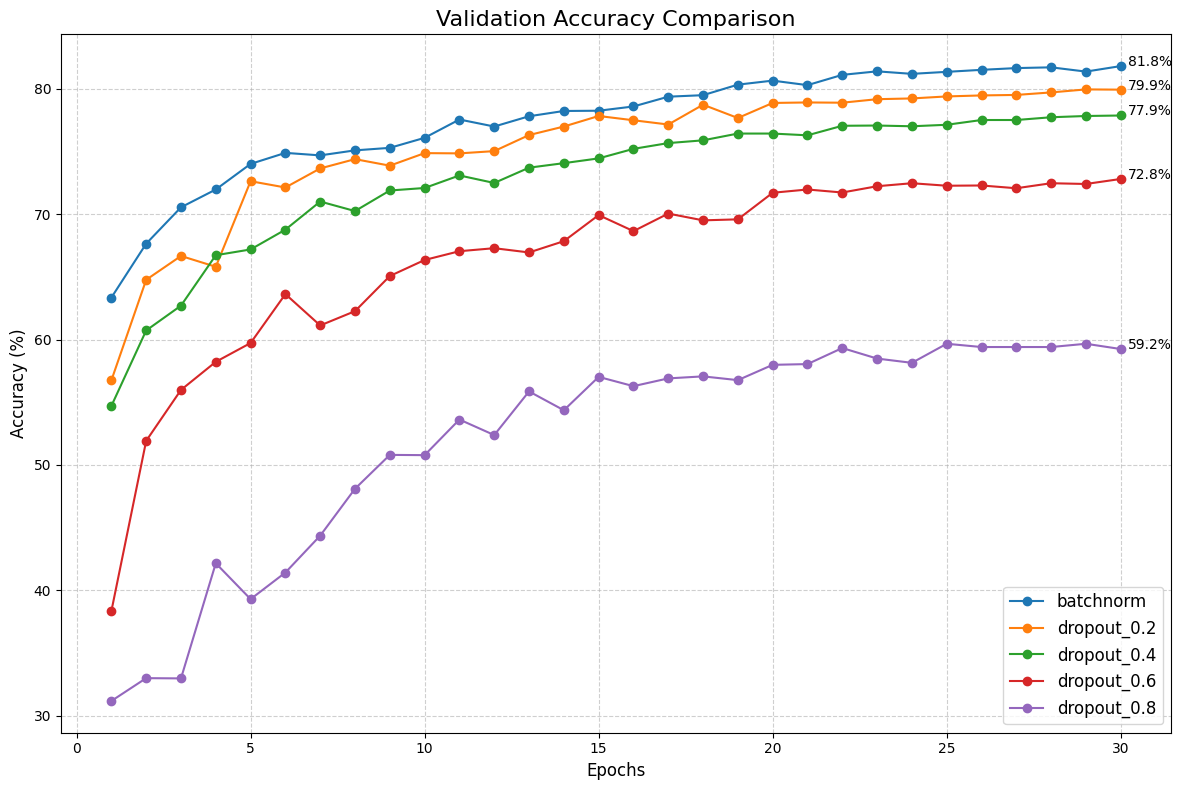

In [16]:
df_results = pd.DataFrame(results_data)
display(df_results)
utils.plot_validation_curves(histories)

This result directly shows that Dropout did not help at all at this point. The higher the dropout chance, the lower the accuracy became throughout the whole training process.

We can be reminded here that Dropout was not applied on the convolutional layers themselves, but on the final classifier. The current result means that whatever it is the classifier sees from the convolutional layers, it is unable to fully learn the patterns in it, even in its training data. Hence why weakening the classifier with Dropout only worsened the result.

Combining Data Augmentation with Batch Normalization was very effective, and it provided the model with much more data and the capacity to improve on it more carefully. The model no longer has the capacity to overfit to the data, since there is so much of it, and thus Dropout becomes an overkill for regularization.

## Weight Decay

The next thing to test is adding Weight Decay to the optimizer. This is a regularization method that applies a penalty to the loss function itself based on the size of the weights, which forces the model to learn a solution of sufficiently small weights.

This constraint helps models avoid being stuck in local minima that seem to give good result but are dependant on a few large weights. Because the model won't be able to overly rely on a handful of pixels to give disproportionate weight it will lead to better distributed learning across the entire model. Besides, small weights would make it easier for the model to apply gradients in small increments.

We will test the current leading model with Weight Decay and see the result.

We also increase the number of epochs to 60. This is because the model plateaus and learns very slowly after around 20 epochs, but there is still improvement. The Cosine scheduler and the early stopping guarantee that training won't continue to the point it causes loss in generalization.

The patience hyperparameter is increased to 10 in direct conjecture with the number of epochs - it merely controls that learning can reach an optimal point even across a large amount of iterations, and doesn't alter the inner training of the model itself.

In [34]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=5e-4)

cos_scheduler = CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-6)

results = train_CNN(model, augtrainloader, valloader, criterion, optimizer, device,
                    epochs=60, early_stopping=True, patience=10, scheduler=cos_scheduler)

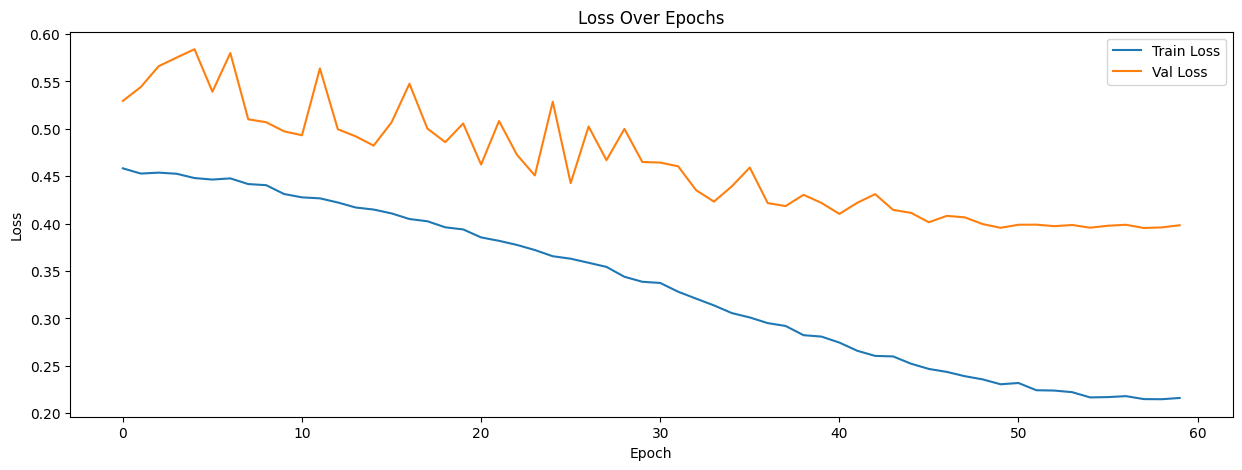

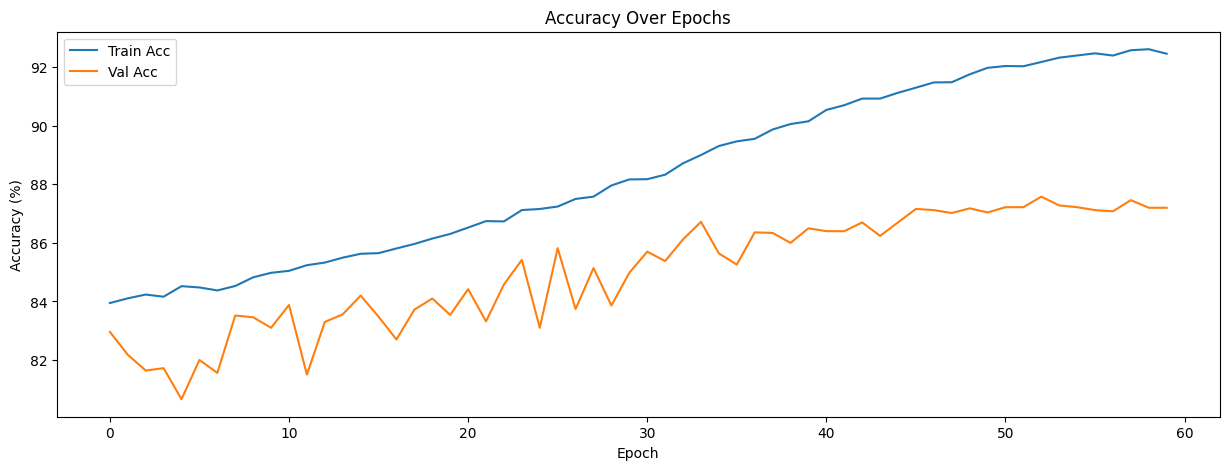

In [35]:
utils.plot_loss(results['train_loss'], results['val_loss'])
utils.plot_acc(results['train_acc'], results['val_acc'])

Over 60 epochs learning plateaued thanks to the scheduler and reached 84% validation accuracy, an improvement of 3%.

We can still test one more thing: it is possible that the new data added by Data Augmentation would be more beneficial for a larger model.

Previously we were averted from testing larger models because of two reasons: First, the images in CIFAR-10 are 32x32 pixels, which isn't much, and if the image is pooled and reduced too many times - or otherwise too many features are extracted from it - meaningful learning collapses as there is not enough to learn (we don't want to end up with a 2x2 image).

But now that we hit a ceiling of 84% accuracy, it is best to check if other models won't manage to break through it by recognizing more complex features.

An additional benefit of testing a CNN with another convolutional layer is that, due to another pooling layer, the final image that goes into the classifier will be twice as small (we double the number of channels but divide by 2 both height and width). This may help the classifier a lot, and justifies trying to use Dropout again.

In [28]:
class DeeperCNN(nn.Module):
    def __init__(self, batch_norm=True, dropout_prob=0.2, m=1):
        super().__init__()
        # Block 1: 32x32x3 in -> 16x16x16 out
        self.conv1a = nn.Conv2d(3, 16 * m, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(16 * m, 16 * m, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1a = nn.BatchNorm2d(16 * m)
        self.bn1b = nn.BatchNorm2d(16 * m)

        # Block 2: 16x16x16 in -> 8x8x32 out
        self.conv2a = nn.Conv2d(16 * m, 32 * m, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(32 * m, 32 * m, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2a = nn.BatchNorm2d(32 * m)
        self.bn2b = nn.BatchNorm2d(32 * m)

        # Block 3 : 8x8x32 in -> 4x4x64 out
        self.conv3a = nn.Conv2d(32 * m, 64 * m, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(64 * m, 64 * m, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3a = nn.BatchNorm2d(64 * m)
        self.bn3b = nn.BatchNorm2d(64 * m)

        # Classifier
        self.fc1 = nn.Linear(4 * 4 * 64 * m, 128)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = self.pool1(F.relu(self.bn1b(self.conv1b(x))))

        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = self.pool2(F.relu(self.bn2b(self.conv2b(x))))

        # Block 3
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = self.pool3(F.relu(self.bn3b(self.conv3b(x))))

        # Classifier
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Evaluation

We test six deeper CNN model configurations under Data Augmentation and with Batch Normalization.

We define a new hyperparameter, m for multiplier. The number of filters in each convolutional layer is multiplied by m. In effect this allows us to test a network with increased width, capable of recognizing a much larger amount of features, with various Dropout configurations.

Besides, p is the hyperparameter for Dropout probability. Dropout is examined out of the assumption that as another block is added to the model, the classifier may start to overfit as the number of inputs it gets decreases by half.

We test these two hyperparameters in a 2x3 grid to search for the optimal configuration, and again we use Weight Decay with more epochs as that proved beneficial beforehand.

In [36]:
models = {
    'm=1, p=0': DeeperCNN(batch_norm=True, dropout_prob=0, m=1).to(device), # just the deeper model, same hyperparameters
    'm=2, p=0': DeeperCNN(batch_norm=True, dropout_prob=0, m=2).to(device), # deeper and wider model
    'm=1, p=0.1': DeeperCNN(batch_norm=True, dropout_prob=0.1, m=1).to(device),
    'm=2, p=0.1': DeeperCNN(batch_norm=True, dropout_prob=0.1, m=2).to(device),
    'm=1, p=0.2': DeeperCNN(batch_norm=True, dropout_prob=0.2, m=1).to(device),
    'm=2, p=0.2': DeeperCNN(batch_norm=True, dropout_prob=0.2, m=2).to(device)
}
results_data = []
histories = dict()

# training for each model
for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=5e-4)

    cos_scheduler = CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-6)

    history = train_CNN(model, augtrainloader, valloader, criterion, optimizer, device,
                        epochs=60, early_stopping=True, patience=10, scheduler=cos_scheduler)

    final_train = history['train_acc'][-1]
    final_val = history['val_acc'][-1]
    results_data.append({
        'Model': name,
        'Train Acc': final_train,
        'Val Acc': final_val,
        'Gap': final_train - final_val
    })
    histories[name] = history

    print(f"{name:<10} | Train Acc: {final_train:.2f}% | Val Acc: {final_val:.2f}%")

m=1, p=0   | Train Acc: 91.78% | Val Acc: 87.26%
m=2, p=0   | Train Acc: 97.85% | Val Acc: 91.00%
m=1, p=0.1 | Train Acc: 90.63% | Val Acc: 86.84%
m=2, p=0.1 | Train Acc: 97.09% | Val Acc: 90.20%
m=1, p=0.2 | Train Acc: 90.21% | Val Acc: 87.44%
m=2, p=0.2 | Train Acc: 96.73% | Val Acc: 90.78%


### Results

,Model,Train Acc,Val Acc,Gap
0,"m=1, p=0",91.784,87.26,4.524
1,"m=2, p=0",97.850,91.00,6.850
2,"m=1, p=0.1",90.628,86.84,3.788
3,"m=2, p=0.1",97.092,90.20,6.892
4,"m=1, p=0.2",90.206,87.44,2.766
5,"m=2, p=0.2",96.728,90.78,5.948


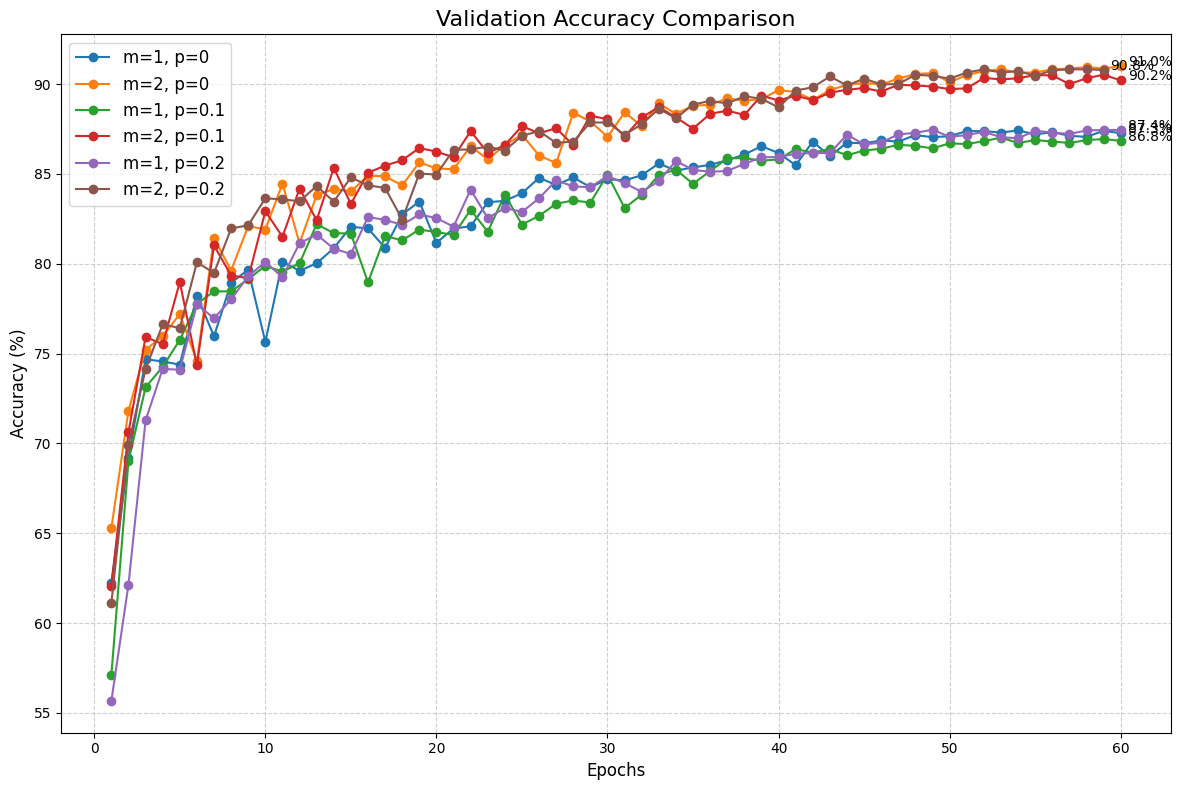

In [37]:
df_results = pd.DataFrame(results_data)
display(df_results)
utils.plot_validation_curves(histories)

We have achieved improvements over the previous attempts in all of the models in this experiment, and of particular note is the configuration {m=2,p=0} which has achieved 91% validation accuracy!

The decision to increase learning time as the model grew proved correct, as the wider model breached 90% accuracy only after about 40 epochs.

In this graph it is clearly visibile that the configurations corresponding to m=1 and m=2 cluster separately. The architecture of the model itself was a much bigger deciding factor on its final performance than the other hyperparameter tested - Dropout, merely a regularizer - and this is why selection of model architecture is usually the first thing tested. Here, however, be re-examining our selection after utilizing Data Augmentation, Batch Normalization and Weight Decay we managed to significantly improve our performance.

It has been proven that excellent accuracy can be reached on the CIFAR-10 dataset by a relatively small classic CNN, with 3 blocks and 128 feature channels, given it is correctly tuned and uses regularization and data augmentation.

Interestingly enough, p=0.2 actually did improve the performance for the smaller deeper model. It can be noted that adding Dropout to the classifier is not really beneficial, but exploring Dropout in cases where the classifier recieves a smaller total amount of features can yield marginal improvement in accuracy.

## Weight Decay Search

Since Weight Decay has been such an effective regularizer during this process that we search for the optimal Weight Decay in the following section.

In [39]:
hyperparameters = {
    'wd=3e-4': 3e-4,
    'wd=5e-4': 5e-4,
    'wd=7e-4': 7e-4,
    'wd=1e-3': 1e-3,
}
results_data = []
histories = dict()

# training for each model
for name, wd in hyperparameters.items():
    model = DeeperCNN(batch_norm=True, dropout_prob=0, m=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=wd)

    cos_scheduler = CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-6)

    history = train_CNN(model, augtrainloader, valloader, criterion, optimizer, device,
                        epochs=60, early_stopping=True, patience=10, scheduler=cos_scheduler)

    final_train = history['train_acc'][-1]
    final_val = history['val_acc'][-1]
    results_data.append({
        'Model': name,
        'Train Acc': final_train,
        'Val Acc': final_val,
        'Gap': final_train - final_val
    })
    histories[name] = history

    print(f"{name:<10} | Train Acc: {final_train:.2f}% | Val Acc: {final_val:.2f}%")

wd=3e-4    | Train Acc: 98.03% | Val Acc: 90.36%
wd=5e-4    | Train Acc: 97.11% | Val Acc: 90.08%
wd=7e-4    | Train Acc: 97.35% | Val Acc: 90.40%
wd=1e-3    | Train Acc: 96.82% | Val Acc: 90.62%


The best results are from wd=1e-3, or 0.001.

The validation accuracy results are slightly lower than what we've seen beforehand with the same hyperparameters (this time the same configuration got 90.08% instead of 91.0%, a decrease of 0.92%). This decrease is purely due to random variance. We have introduced a variety of random factors into the training process: random initialization of weights, random data augmentation and even the way GPU handles small numbers are all nondeterministic. Still, a variance of below 1% is acceptable and expected.

These are the hyperparameters that proved the best result, creating a model that outputs ~91% validation accuracy on CIFAR-10:
* A model with 3 blocks of double convolutional layers of 3x3 filters, which include 2x2 pooling and batch normalization. The number of features increases from 32 to 128 by factors of 2.
* The final classifier is a fully connected neural network with 128 hidden neurons, with ReLU activation.
* Adam optimizer with learning rate 0.001, weight decay 0.001 and Cosine Anneal learning rate decay.
* 60 epochs of training with early stopping with a patience of 10.
* 0 dropout.
* Data augmentation by random cropping and random flipping.

It is possible that further tuning and examination can yield better performance, but at a diminishing return, as further improvements would be in the range of singular digits of accuracy. Enlarging the model further may marginally increase accuracy at the cost of almost doubling the number of parameters again, and if it grows too large it may lose its generalization ability due to the vanishing gradients problem.

## Final Test

The optimal model is replicated and its models are saved, then it is finally tested on the test subset to assess its true performance.

As stated above, random variance may cause fluctuations of up to 1% in a retrained model's accuracy.

The test subset is always saved for last and changes are not made based on the results of its evaluation. This is so that it can represent a true evaluation of the model without a risk of our tuning making the model adapted to the particular testing data. It is a purely blind test.

In [40]:
model = DeeperCNN(batch_norm=True, dropout_prob=0, m=2).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-3)
cos_scheduler = CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-6)

results = train_CNN(model, augtrainloader, valloader, criterion, optimizer, device,
                    epochs=60, early_stopping=True, patience=10, scheduler=cos_scheduler)
torch.save(model.state_dict(), "model_weights.pth")

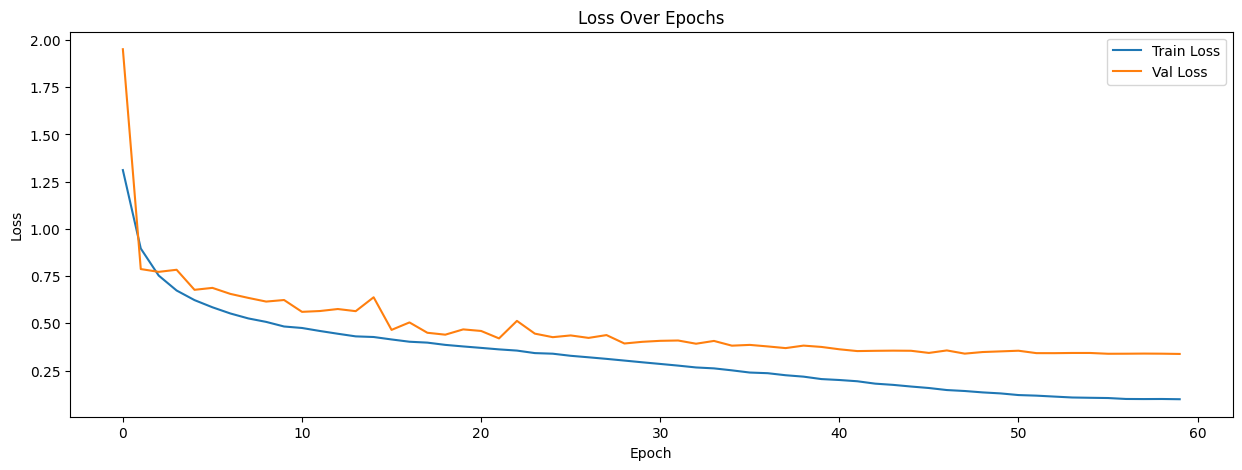

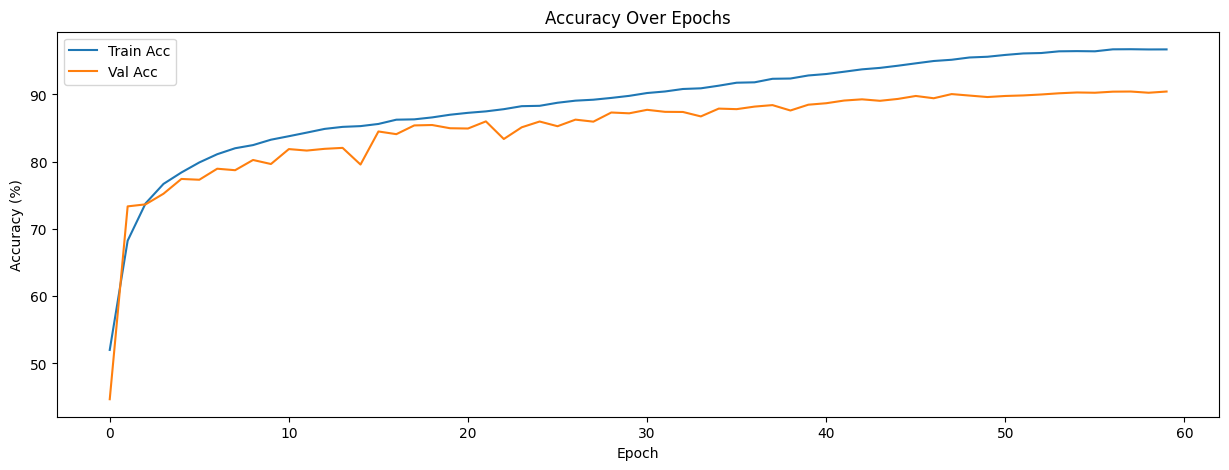

Final Validation Accuracy: 90.62%, Val-Train Gap: 6.20%


In [43]:
utils.plot_loss(results['train_loss'], results['val_loss'])
utils.plot_acc(results['train_acc'], results['val_acc'])

final_train = history['train_acc'][-1]
final_val = history['val_acc'][-1]
gap = final_train - final_val

print(f"Final Validation Accuracy: {final_val:.2f}%, Val-Train Gap: {gap:.2f}%")

In [44]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.32, Test Accuracy: 90.66%


## Conclusions
In the last three notebooks we have followed a development path for the goal of building a model that can effectively categorize the CIFAR-10 dataset. We went from simple feedforward neural networks, and after seeing their shortcomings we made a move into CNNs, and finally regularization allowed us to make significant improvements and reach accuracy of 90.6% on the test set. This marks major success in our little quest.

We have seen how the convolutional layers allow CNNs to capture spatial relations and complex patterns that are much harder to learn with simple feedforward networks. We have also seen how regularization techniques like dropout and weight decay can help prevent overfitting and improve generalization. We've seen when each of these techniques is effective and when to search for their optimization. Finally, we have seen how data augmentation can help improve the model's performance on unseen data.

Overall, we have learned a lot about how to build and train effective CNNs for image classification tasks, and we have seen how these techniques can be applied to a wide range of problems.